In [1]:
import pandas as pd
%cd /home/ltchen/gnnpp
import sys
import json
import copy
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
import shap
import matplotlib.pyplot as plt
from exploration.get_graphs_and_data import *
from utils.explainability_utils import *
from utils.plot import *
import seaborn as sns

/home/ltchen/gnnpp


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()

all_feature_names, grouped_list = get_feature_list()
grouped_list = ['id',
 'orography',
 'altitude',
 'latitude',
 'longitude',
 'cape',
 'sd',
 'stl1',
 'swvl1',
 't2m',
 'tcc',
 'tcw',
 'tcwv',
 'u10',
 'u100',
 'v10',
 'v100',
 'vis',
 'cp6',
 'mn2t6',
 'mx2t6',
 'p10fg6',
 'slhf6',
 'sshf6',
 'ssr6',
 'ssrd6',
 'str6',
 'strd6',
 'tp6',
 'z',
 'q',
 'u',
 'v',
 't',
 'doy']

## permutation importance is saved in a wrong format
fix this

In [66]:
leadtimes = ["24h", "72h", "120h"]
data_type = "rf"
graph_name = "g4"
drn = False
dfs = []
for leadtime in leadtimes:
    JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name, drn=drn)
    print(RESULTPATH)

    old_df = pd.read_csv(os.path.join(RESULTPATH, f"permutation_importance_{data_type}.csv"))
    old_df = old_df.drop(columns=["CRPS_mean", "CRPS_std"])

    df_pivot = (old_df.melt(id_vars="Feature", var_name="Shuffle", value_name="CRPS")
                      .pivot(index="Shuffle", columns="Feature", values="CRPS"))

    df_pivot = df_pivot.reset_index(drop=True)

    df_pivot["leadtime"] = leadtime

    crps_line = next(line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:'))
    crps_value = float(crps_line.split(':')[1].strip())
    df_pivot["no_permutation"] = crps_value

    cols = ["leadtime"] + [col for col in df_pivot.columns if col != "leadtime"]
    df_pivot = df_pivot[cols]

    if "cos" in df_pivot.columns:
        df_pivot.rename(columns={"cos": "doy"}, inplace=True)

    dfs.append(df_pivot)

df = pd.concat(dfs, ignore_index=True)

# Importance
for column in df.columns.difference(["Feature", "Shuffle", "leadtime", "no_permutation"]):
    df[column] = (df[column] - df["no_permutation"]) / df["no_permutation"]
df.drop(columns=["no_permutation"], inplace=True)
def normalize_category(group):
    group = group / group.mean().sum()
    return group

df = df.groupby("leadtime").apply(normalize_category).reset_index().drop(columns=["level_1"])

# Save Leadtime
leadtime = df["leadtime"].copy()
df.drop(columns=["leadtime"], inplace=True)
# Sort by mean importance
keys = df.mean(axis=0).sort_values(ascending=False).index
df = df.loc[:,keys]
df["leadtime"] = leadtime

df = pd.melt(df, id_vars=["leadtime"], var_name="feature", value_name="importance")
# df
df['feature'] = df['feature'].replace({
    'altitude': 'alt',
    'orography': 'orog',
    'latitude': 'lat',
    'longitude': 'lon'
})

/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g4_24h/
/home/ltchen/gnnpp/leas_trained_models/sum_stats_72h/g4_72h/
/home/ltchen/gnnpp/leas_trained_models/sum_stats_120h/g4_120h/


In [67]:
FIGUREPATH = os.path.join(DIRECTORY, 'figures/results/permutation_importance')
os.makedirs(FIGUREPATH, exist_ok=True)

sns.set_style("whitegrid")
c = [get_color(lead_time)(0.6) for lead_time in ["24h", "72h", "120h"]]
df.sort_values(by=['importance'], ascending=False, inplace=True)

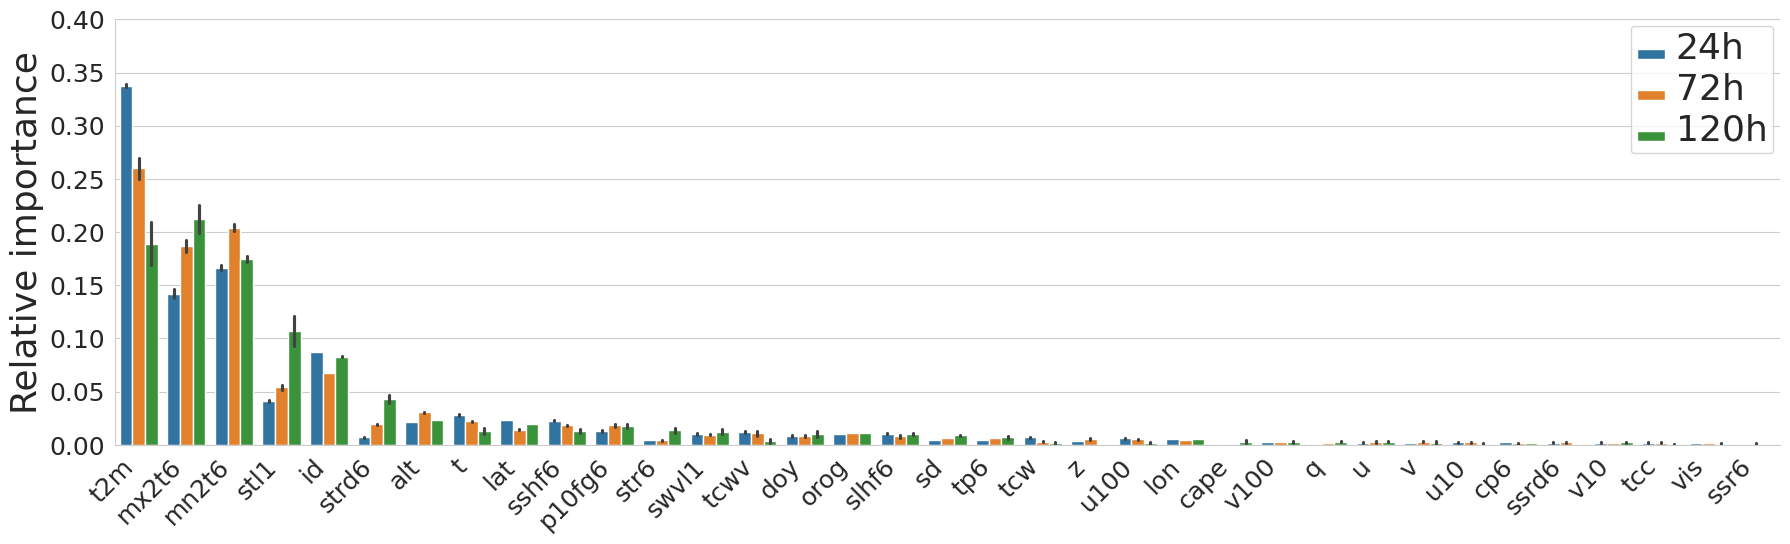

In [68]:
import matplot2tikz
g = sns.catplot(data=df, kind="bar",
                x="feature", y="importance", hue="leadtime", hue_order=["24h", "72h", "120h"],
                errorbar="sd", height=6, aspect=3,
                legend_out=None)
g.set_axis_labels("", "Relative importance", fontsize=26)
g.set_xticklabels(fontsize=18)
g.set_yticklabels(fontsize=18)

g.legend.set_title("")
for text in g.legend.texts:
    text.set_fontsize(26)
g.set(ylim=(0, 0.4))
g.set_xticklabels(rotation=45, ha="right")
plt.tight_layout()
g.figure.subplots_adjust(bottom=0.25)
g.savefig(os.path.join(FIGUREPATH, f"perm_imp_{graph_name}_{data_type}.pdf"))


# Save
# tikzplotlib_fix_ncols(g.ax)
# tikzplotlib.save(f"figures/PI_{DATASET}.tex")
# matplot2tikz.save(os.path.join(FIGUREPATH, f"perm_imp_{graph_name}_{data_type}.tex"))

## old

In [5]:
times_to_shuff = 3
crps_shuff_cols = ['Feature'] + [f"CRPS_{shuffle_id}" for shuffle_id in range(0, times_to_shuff)]
print(crps_shuff_cols)

dfs = []
for leadtime in leadtimes:
    JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name, drn=drn)
    print(RESULTPATH)
    old_df = pd.read_csv(os.path.join(RESULTPATH, f"permutation_importance_{data_type}.csv"))
    df_long = old_df[crps_shuff_cols].melt(id_vars=['Feature'], var_name='Shuffle', value_name='CRPS')
    df_long['Shuffle'] = df_long['Shuffle'].str.split('_').str[1]
    df_long['leadtime'] = leadtime
    crps_value = float([line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:')][0].split(':')[1])
    print(crps_value)
    new_df = df_long
    new_df['relCRPS'] = (new_df['CRPS'] - crps_value) / crps_value
    # new_df = new_df[['Feature', 'relCRPS', 'leadtime']]
    print(new_df)
    dfs.append(new_df)
df = pd.concat(dfs, axis=0)
df

['Feature', 'CRPS_0', 'CRPS_1', 'CRPS_2']
/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g2_24h/
0.6193296252351883
       Feature Shuffle      CRPS leadtime   relCRPS
0           id       0  0.966489      24h  0.560541
1    orography       0  0.642617      24h  0.037601
2     altitude       0  0.684284      24h  0.104879
3     latitude       0  0.676178      24h  0.091790
4    longitude       0  0.638509      24h  0.030968
..         ...     ...       ...      ...       ...
100          q       2  0.624146      24h  0.007777
101          u       2  0.630554      24h  0.018124
102          v       2  0.625551      24h  0.010045
103          t       2  0.757705      24h  0.223428
104        cos       2  0.651488      24h  0.051925

[105 rows x 5 columns]
/home/ltchen/gnnpp/leas_trained_models/sum_stats_72h/g2_72h/
0.8459441868073004
       Feature Shuffle      CRPS leadtime   relCRPS
0           id       0  1.170429      72h  0.383577
1    orography       0  0.860303      72h  0.0

,Feature,Shuffle,CRPS,leadtime,relCRPS
0,id,0,0.966489,24h,0.560541
1,orography,0,0.642617,24h,0.037601
2,altitude,0,0.684284,24h,0.104879
3,latitude,0,0.676178,24h,0.091790
4,longitude,0,0.638509,24h,0.030968
...,...,...,...,...,...
100,q,2,1.186304,120h,0.002380
101,u,2,1.182177,120h,-0.001107
102,v,2,1.185598,120h,0.001784
103,t,2,1.222166,120h,0.032682


In [6]:
f_list = ['stl1_mean', 'stl1_std']
if isinstance(f_list, list):
    f = f_list[0].split("_")[0]
else:
    f = f_list
print(f)


stl1


In [7]:
def normalize_category(group):
    group = group / group.mean().sum()
    return group

df = df.groupby(["leadtime", 'Feature']).apply(normalize_category).reset_index().drop(columns=["level_1"])
df

TypeError: unsupported operand type(s) for /: 'str' and 'float'

In [10]:
# was berechne ich hier überhaupt?
df['normalized_importance'] = df.groupby(['leadtime'])['relCRPS'].transform(
    lambda x: (x / x.sum())
)
df.sort_values(by=['normalized_importance'], ascending=False, inplace=True)
df

,Feature,Shuffle,CRPS,leadtime,relCRPS,normalized_importance
9,t2m,0,2.213471,24h,2.573979,0.122121
79,t2m,2,2.208298,24h,2.565627,0.121724
44,t2m,1,2.116169,24h,2.416870,0.114667
90,mx2t6,2,1.661659,120h,0.404037,0.073979
79,t2m,2,1.534252,72h,0.813656,0.073620
...,...,...,...,...,...,...
40,cape,1,0.846113,72h,0.000199,0.000018
59,ssr6,1,0.845923,72h,-0.000025,-0.000002
88,cp6,2,1.183173,120h,-0.000265,-0.000048
25,ssrd6,0,0.845402,72h,-0.000641,-0.000058


In [11]:
pi_df = df.groupby(['leadtime', 'Feature']).sum(numeric_only=True).sort_values(by='normalized_importance', ascending=False)

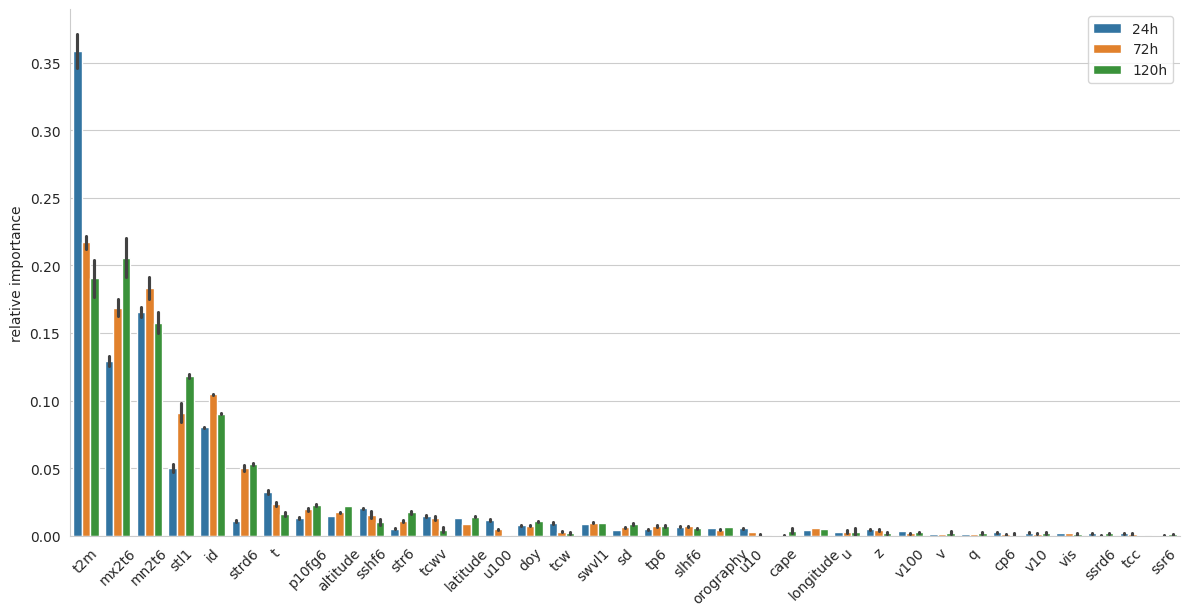